# Boosted Decision Trees $H \rightarrow ZZ \rightarrow 4\ell$ (VBF vs. ggF) 
 >__Created__:  2018 Harrison B. Prosper
  __Updated__: 04-Jan-2019 HBP


### Introduction

Given a loss function $L(y, f)$, where $y$ is a numerical label associated with data $x$, and a sufficiently flexible function $f(x, w)$ that inhabits a function space $F$, the basic task of classification and regression is to $choose$ an acceptable function $f(x, w)$ from $F$. The loss function measures the *unacceptability* of your choice. The most widely used loss function is the __quadratic__ loss, given by 

$$L(y, f) = (y - f)^2.$$

A function $f$ is chosen from its function space by minimizing the loss function. In practice, it is much better to minimize the $average$ loss

$$R(w) = \frac{1}{N} \sum_{n=0}^N L(y_n, f(x_n, w),$$

which is called the empirical risk function, or in machine learning, the loss function! In general, it is impossible to navigate the function space towards an acceptable choice without placing limits on which functions in the space are acceptable. This is done by adding a *constraint* $C(w)$ to $R_N(w)$, which constrains the parameters associated with the function $f(x, w)$. For example, you may prefer to guide the minimization towards smooth functions. Typically, the constraint increases as one moves away from an acceptable function choice.

The __risk function__ is the limit of $R(w)$ as $N \rightarrow \infty$ and is given by

$$R[f] = \int \int L(y, f) \, p(y, x) \, dy\, dx,$$

where $p(y, x) = p(y | x) \, p(y)$ is the joint probability function of the data $(y, x)$. Notice that $R[f]$ depends on $all$ values of the function $f(x, w)$. A quantity that depends simulataneously on all the values of a function  is called a $functional$. This distibguishes it from a $function$, which depends at most on a finite number of function values.

#### Quadratic loss 

Suppose we use the quadratic loss in $R[f]$ then we obtain
\begin{align*}
        R[f] & = \int \int (y - f)^2 \, p(y, x) \, dy\, dx,\\
            & = \int \left[\int (y - f)^2 \, p(y | x)\, p(x) \, dy\right] \, dx.
\end{align*}
Let's now minimize $R[f]$ with respect to the function $f$. Happily, *functional differentiation* is similar to ordinary differention so we can write

\begin{align*}
        \frac{\delta R[f]}{\delta f} & = - 2 \int \left[\int (y - f) \, p(y | x) \, dy\right] \, p(x) \, dx\\
        & = - 2 \int \left[\int (y - f(x, w)) p(y | x) \, dy\right]  \, p(x) \, dx.
\end{align*}
__If__ our function $f(x, w)$ is sufficiently flexible, then the functional derivative $\delta R[f] / \delta f$ can reach zero. If this happens then we can write

\begin{align*}
        - 2 \int \left[\int (y - f(x, w)) p(y | x) \, dy\right]  \, p(x) \, dx & = 0,
\end{align*}
This equation must be zero for $all$ values of $x$. This is guaranteed if and only if the term in
brackets is zero, that is, if 

$$\boxed{\,\, f(x, w) = \int y \, p(y \, | \, x) \, dy\,\,},$$

that is, minimizing the empirical risk $R(w)$ yields a function $f(x) \equiv f(x, w^*)$ that $approximates$ the conditional average of $y$, where the condition is "a given set of input data $x$". Therefore, if you use a machine learning method with the quadratic loss, your machine learning method will yield an $f$ that approximates the average of $y$ for a given $x$. It is important to be aware of this because it may be that the average is not what you want. Different loss functions will yield different mathematical results for $f$. For example, $L(y, f) = |y - f|$ yields the *median* of $y$. For the AdaBoost algorithm used here, the risk function is

$$R[f] = \int \int \exp(-y \, f(x, \mathbf{w})) \, p(y, x) \, dy \, dx,$$

where 
 $$f(x, \mathbf{w}) = \sum_{n=1}^N \alpha_n T(x, w_n), \quad N \rightarrow \infty$$
 
and $T(x, w)$ is a decision tree (that is, a *piece-wise constant* function).

Although $f(x, w)$ cannot be interpreted as a probability, the following can be,

$$p(x) = \frac{1}{1 + \exp(-2 y \, f(x, w))}.$$

### Exercise
  1. Build a boosted decision tree, using __AdaBoostClassifier__, to discriminate between VBF and ggF production of the Higgs boson.

In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 20
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}

mp.rc('font', **font)

### Load data into memory
An important discipline in machine learning is dividing the data into a part that is used for training, that is, finding a suitable function from the function space, and a part that is used for testing the quality of the choice. *Why is this good practice?*

__Note__: the function train_test_split returns a pair of pandas DataFrames.
The data are in comma delimited files, which can be read using the __pandas__ function __read_csv__. This creates pandas __DataFrames__ called *train_data* and *test_data*.

In [3]:
train_data = pd.read_csv('../../datasets/hzz_vbf_ggf_train.csv') 
test_data  = pd.read_csv('../../datasets/hzz_vbf_ggf_test.csv')
train_data[:10]

,Z1mass,Z2mass,pt4l,eta4l,massjj,detajj,HT,dRZ1Z2,target
0,90.29,14.06,215.80,-0.1829,86.08,0.3362,324.50,0.4905,0.0
1,86.57,37.24,217.80,0.3579,310.20,2.8900,219.90,0.1691,0.0
2,97.37,13.46,138.90,-0.8100,220.40,2.9030,106.30,0.4296,0.0
3,91.96,18.97,54.89,-2.6840,583.50,5.0130,101.60,1.7580,1.0
4,91.45,12.06,187.80,-0.5866,55.98,0.3771,220.20,0.6852,1.0
5,91.56,23.99,70.43,-1.4530,76.01,1.0250,96.66,1.3180,0.0
6,90.72,22.09,56.87,-0.6028,369.80,5.0490,60.70,1.1900,1.0
7,89.51,14.47,79.13,-0.7406,606.80,5.8350,70.59,0.9895,1.0
8,90.99,29.19,131.80,-1.5150,400.70,3.8210,119.00,0.5383,0.0
9,92.10,26.99,86.19,-1.3920,552.10,4.7950,106.70,1.4280,1.0


In [4]:
print("len(train_data): %10d" % len(train_data))

len(train_data):      50000


### Plot training data

In [5]:
def plotData(data, xmin=0, xmax=8, ymin=0, ymax=2000, N=1000, ftsize=FONTSIZE):
    
    # set size of figure
    plt.figure(figsize=(8, 8));
    
    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'$|\Delta\eta|_{jj}$', fontsize=24)
    plt.ylabel(r'$m_{jj}$ (GeV)', fontsize=24)
    
    # split into sig and bkg for the purposes of plotting
    sig = data[data.target > 0.5][:N]
    bkg = data[data.target < 0.5][:N]

    plt.scatter(sig.detajj, sig.massjj, marker='o',
                s=50, c='blue', alpha=0.3, label='VBF')
    pl.legend(loc='upper left') # activate legend
    
    plt.scatter(bkg.detajj, bkg.massjj, marker='*',
                s=100, c='red',  alpha=0.3, label='ggF')
    pl.legend(loc='upper left') # activate legend
    plt.tight_layout()
    plt.savefig('higgs_vbf_ggf_variables.png')
    plt.show()

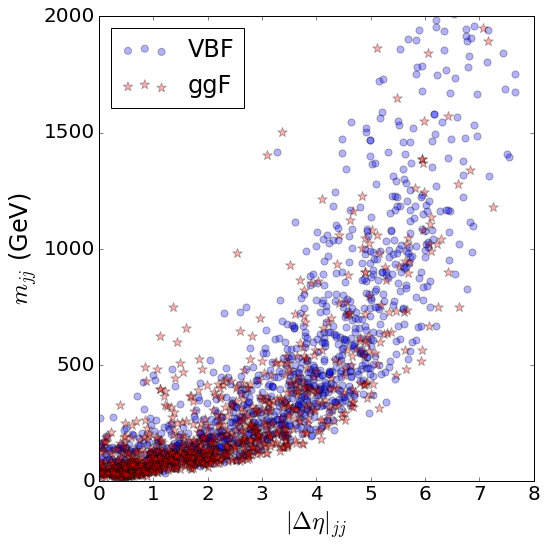

In [6]:
plotData(train_data)

### Prepare data for training/testing
  1. Create a scaling object (StandardScaler) to standardize each variable to zero mean and unit variance.
  1. For each variable specified in the (Python) list *names*, compute the linear transformation that standardizes the variable. Use the DataFrame *train_data*.
  1. Transform *train_data*, creating a numpy __ndarray__ and map the target to an __ndarray__.
  1. Transform *test_data*, creating a numpy __ndarray__, and map the target to an __ndarray__.
  1. Return the input training and test data and their associated targets

In [7]:
def standardize_data(train_data, test_data, inputs):
    scaler  = StandardScaler()
    scaler.fit(train_data[inputs])
    
    X_train = scaler.transform(train_data[inputs])
    X_test  = scaler.transform(test_data[inputs])
    y_train = np.array(train_data['target'])
    y_test  = np.array(test_data['target'])

    return (X_train, X_test, y_train, y_test, scaler)

In [8]:
inputs = ['detajj', 'massjj']
X_train, X_test, y_train, y_test, scaler = standardize_data(train_data, 
                                                            test_data, 
                                                            inputs)
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

### Define function space 
Our function spaces are subsets of the space of all piece-wise constant functions that can be defined by histograms created through recursive binary partitioning. In the Python map *params*, we specify possible combinations of the minimum number of samples per bin, *i.e.*, leaf (*min_samples_leaf*), and the number of histograms (trees) to be averaged over (*n_estimators*) using the __AdaBoost__ coefficients.

  1. Create a decision tree classifier
  1. Give it to the AdaBoost algorithm
  1. Specify the triplets of parameters than uniquely define the function space. Note the use of *base_estimator__* to specify that the paramter pertains to the DecisionTreeClassifier and not to the AdaBoostClassifier.
  
__Try__:
  
  1. Changing the possible combinations of parameters and see if you can get the training and test scores closer.

In [9]:
dt  = DecisionTreeClassifier(max_depth=6,
                             min_samples_leaf=1)

ada = AdaBoostClassifier(dt, 
                         n_estimators=100, 
                         random_state=1,
                         algorithm="SAMME")

# possible combinations of params
params = {'base_estimator__min_samples_leaf': [100, 200, 300, 400, 500],
          'n_estimators' : [100, 200, 300, 400, 500]}

### Choose a function from the function space, aka train a classifier!
Use __RandomizedSearchCV__ to run many trainings, each with a randomly chosen set of parameters from *params* and find the best classifier. This tool uses 3-way __cross-validation__. The training data are split 3 ways; 2/3 are used for training and the other 1/3 for validation and the training is done 3 times, each with a different 2/3 of the training data.

  1. Create a randomized cross-validation object passing to it the AdaBoost algorithm, the *params* map and the number of sets of parameters to try.
  1. Train the classifiers (by calling the *fit* function)
  1. Print the best set of parameters.
  1. Get the associated classifier (*adabest*).
  1. Print the scores.
  1. Save the classifier and scaling object to a pickle file.

In [10]:
print "*** TRAINING ***"
ntrain = 5000
rcv = RandomizedSearchCV(ada, params, n_iter=20, verbose=1)
rcv.fit(X_train[:ntrain], y_train[:ntrain])

print "Best set of parameters: %s" % rcv.best_params_

adabest = rcv.best_estimator_
adabest.fit(X_train, y_train)

print("Training set score: %f" % adabest.score(X_train, y_train))      
print("Test set score:     %f" % adabest.score(X_test,  y_test))

filename = 'higgs_vbf_ggf_bdt.pkl'
print "save to %s" % filename
joblib.dump([adabest, scaler], filename)

*** TRAINING ***
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.5min finished


Best set of parameters: {'n_estimators': 200, 'base_estimator__min_samples_leaf': 500}
Training set score: 0.721140
Test set score:     0.678600
save to higgs_vbf_ggf_bdt.pkl


['higgs_vbf_ggf_bdt.pkl']

In [11]:
p = adabest.predict_proba(X_train)
p[:10]

array([[0.50410349, 0.49589651],
       [0.50081367, 0.49918633],
       [0.50572634, 0.49427366],
       [0.48895477, 0.51104523],
       [0.5165721 , 0.4834279 ],
       [0.51355989, 0.48644011],
       [0.49862988, 0.50137012],
       [0.48968616, 0.51031384],
       [0.49783066, 0.50216934],
       [0.48949112, 0.51050888]])

### Compute class probabilities and plot their distributions
The function *predict_proba* returns an __ndarray__ of shape (number-of-rows, 2). The second column contains the "class probabilities". Unfortunately, these are not computed correctly in *sklearn*, so we shall use our own version of predict_proba. 

The __predict__ function returns 1 if $f(x) > 0$ and 0 otherwise, where $f(x)$ is a tree. We map the values to $+1$ and $-1$, respectively, which is what the AdaBoost algorithm actually returns for each tree. Then, the matrix $$s_{ij} = w_i \, f(x_j)$$ is computed, where $i$ indexes the $i^\textrm{th}$ tree and $j$ the $j^\textrm{th}$ test pattern. Next the sums $$F(x_j) = \sum_{i=1}^N w_i \, f(x_j)$$ are computed and finally the probabilities
$$p(x_j) = \textrm{logistic}(2\,F(x_j)).$$

In [12]:
def predict_proba(ada, X_test):
    trees   = ada.estimators_
    weights = ada.estimator_weights_
    scores  = [((2*t.predict(X_test)-1)*w).tolist() for (t, w) in zip(trees, weights)]
    F = [0.0]*len(X_test)
    for j in range(len(X_test)):
        for i in range(len(trees)):
            F[j] += scores[i][j]
    F = np.array(F)
    p = 1.0/(1 + np.exp(-2*F))
    return p

In [13]:
p = predict_proba(adabest, X_test)

In [14]:
def plotDistribution(p, y_test, fgsize=(12, 6), arange=(0, 1), nbins=25):
    # separate probabilities into those for ggf and vbf
    p_ggf = map(lambda x: x[0], filter(lambda x: x[-1], zip(p, y_test < 0.5)))
    p_vbf = map(lambda x: x[0], filter(lambda x: x[-1], zip(p, y_test > 0.5)))
    
    # set size of figure
    plt.figure(figsize=fgsize)
    plt.hist(p_ggf,
             bins=nbins, 
             color=(1,0,0),
             alpha=0.3,
             range=arange, 
             normed=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (ggF)')
    pl.legend(loc='upper left',
              fontsize=18) # show legend using specified "label"
    
    plt.hist(p_vbf,
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=arange, 
             normed=True, 
             label=r'$H \rightarrow ZZ \rightarrow 4\ell$ (VBF)')
    pl.legend(loc='upper left',
              fontsize=18) # show legend using specified "label"
    
    plt.savefig("higgs_vbf_ggf_bdt_distribution.png")
    plt.show()

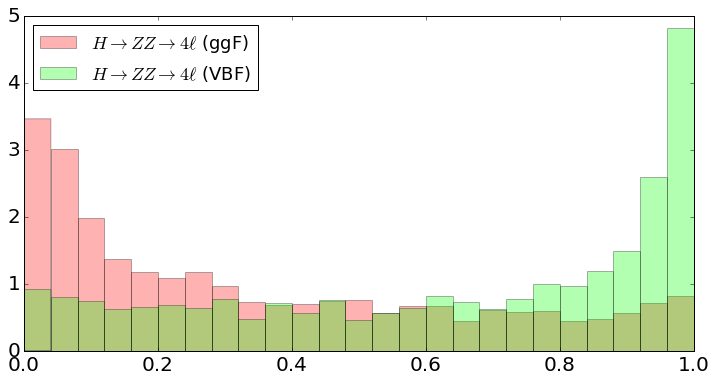

In [15]:
plotDistribution(p, y_test)

In [16]:
def plotROC(y_test, p):
    ggf, vbf, _ = roc_curve(y_test, p)
    roc_auc = auc(ggf, vbf)
    plt.figure(figsize=(8, 8))

    plt.plot(ggf, vbf, color='red',
             lw=2, label='ROC curve, AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('fraction of ggF events')
    plt.ylabel('fraction of VBF events')
    plt.legend(loc="lower right", fontsize=18)
    plt.show()

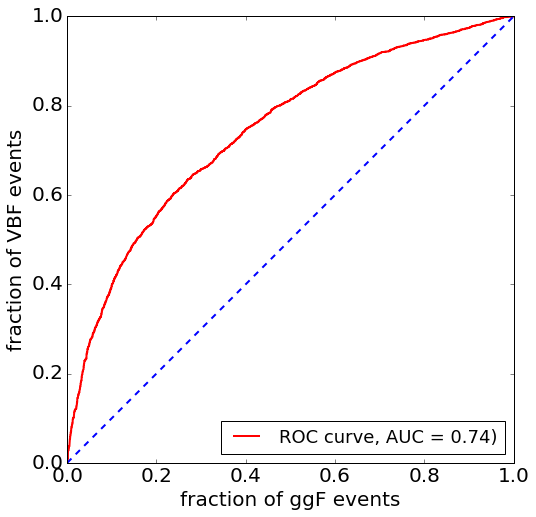

In [17]:
plotROC(y_test, p)

### Plot trees
This requires the __dot__ command to convert a *.dot* file to a *.png* file

In [23]:
# Visualize first tree
#trees = adabest.estimators_
#export_graphviz(trees[0], 
#                out_file='higgs_vbf_ggf_bdt_0.dot', 
#                feature_names = inputs,
#                class_names   = ['ggF', 'VBF'],
#                rounded = True, proportion = False, filled = True)
#!dot -Tpng higgs_vbf_ggf_bdt_0.dot -o higgs_vbf_ggf_bdt_0.png -Gdpi=600